In [45]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper



In [46]:
api_wrapper_arxiv= ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [47]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [48]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()


In [19]:
tavily.invoke("What is AI")

[{'title': 'What is Artificial intelligence (AI)?',
  'url': 'https://www.mtu.edu/computing/ai/',
  'content': "# What is Artificial intelligence (AI)?\n\nArtificial intelligence (AI) encompasses the fields of computer and data science focused on building machines with human intelligence to perform tasks like learning, reasoning, problem-solving, perception, and language understanding. Instead of relying on explicit instructions from a programmer, AI systems learn from data that enables them to handle complex problems and simple repetitive tasks, improving how they respond over time.\n\nAI handles many tasks faster with exceptional accuracy and reliability, freeing humans from repetitive and tedious chores. Businesses and organizations save time and money by automating and optimizing routine processes, using the technology to stay connected with customers and gain a competitive edge. [...] In healthcare, AI is improving medical diagnostics, enabling personalized treatments, and assisti

In [49]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")




In [24]:
tools=[arxiv, wiki, tavily]

In [50]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen/qwen3-32b")


In [26]:
llm.invoke("What is AI")

AIMessage(content='<think>\nOkay, the user is asking what AI is. Let me start by breaking down the concept. AI stands for Artificial Intelligence, which is a field in computer science. I should explain that it\'s about creating machines or software that can perform tasks requiring human-like intelligence. But I need to be clear and not too technical.\n\nFirst, mention the definition. Then maybe list some common applications so the user can relate. Things like virtual assistants, recommendation systems, self-driving cars. That makes it more tangible.\n\nI should also differentiate between narrow AI and general AI. Most current examples are narrow, focused on specific tasks. General AI is still theoretical. Maybe give examples of each to clarify.\n\nDon\'t forget to touch on the history briefly. When did AI start? The 1950s with the Dartmouth Conference, and the development of neural networks over time. Mentioning key milestones like deep learning and big data\'s role in recent advanceme

In [64]:
llm_with_tools = llm.bind_tools(tools=tools)

In [ ]:
llm_with_tools.invoke("What is ReAct in AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about "ReAct in AI." I need to figure out what ReAct refers to. Let me start by recalling if I know this term. ReAct might be a framework or methodology in AI. Since I\'m not entirely sure, I should check reliable sources.\n\nFirst, I\'ll try the Wikipedia function. Maybe there\'s a page explaining ReAct. If that doesn\'t work, perhaps arXiv has a paper on it. Alternatively, using the Tavily search could help find recent information. Let me start with Wikipedia since it\'s a good starting point for definitions.\n', 'tool_calls': [{'id': 'jtk0hdtsm', 'function': {'arguments': '{"query":"ReAct AI"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 148, 'prompt_tokens': 353, 'total_tokens': 501, 'completion_time': 0.290434731, 'completion_tokens_details': {'reasoning_tokens': 122}, 'prompt_time': 0.013904821, 'prompt_tokens_details': None, 'queue_tim

In [66]:
llm_with_tools.invoke("Who is the current barcelona's best footballer?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking who the current Barcelona\'s best footballer is. First, I need to figure out what "current" means here. Since football teams have lineups that change, I should consider the most recent season, probably 2023-2024.\n\nI remember that Barcelona has had some key players in recent years, like Lionel Messi, but he left in 2021. Now, players like Robert Lewandowski, Gavi, Frenkie de Jong, and maybe young talents like Lamine Yamal could be contenders. But I\'m not 100% sure about their current status or performance stats.\n\nTo get the most accurate and up-to-date information, I should use a reliable source. The user mentioned "current," so checking recent sources is important. The tools available include Wikipedia, arXiv (which is for academic papers, not relevant here), and Tavily Search. Tavily is described as a search engine for current events, so that\'s the best choice here.\n\nI\'ll use Tavily to sea

In [67]:
llm_with_tools.invoke("What is AI and RAG?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking, "What is AI and RAG?" Let me break this down. First, AI is a broad term, but I should define it clearly. Then RAG, which I know stands for Retrieval-Augmented Generation. But wait, maybe the user is asking about both AI in general and RAG specifically. Let me confirm.\n\nI need to check if RAG is a specific type of AI model or a different concept. From what I remember, RAG is a framework that combines retrieval from external sources with a language model\'s generation. So it\'s not just another AI model but an approach. But to be thorough, maybe I should look up the exact definition of RAG. However, since I have access to tools like Wikipedia and arXiv, perhaps I should use those.\n\nWait, the user might want a concise explanation without external sources. But since I can use tools, maybe I should use the tavily search to get up-to-date information. Alternatively, if RAG is a well-established term,

In [52]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

In [53]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [54]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

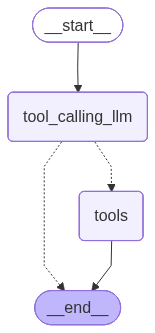

In [68]:
def tool_calling_llm(State: State):
    return{"messages":[llm_with_tools.invoke(State["messages"])]}



builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))


builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools",END)   

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
messages = graph.invoke({"messages":"What is 1+1"})
for m in messages['messages']:  
    m.pretty_print()

================================ Human Message =================================

What is 1+1
================================== Ai Message ==================================

The answer to 1 + 1 is **2**. This is a basic arithmetic operation where adding one unit to another results in two units. Let me know if you'd like help with anything else!
